# Demonstrate Unscented Kálmán Filter (UKF)
Show using a Kálmán filter to estimate the transient state of a Equivalent Circuit Model (ECM) of a batter.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from moirae.models.ecm import EquivalentCircuitModel as ECM
from moirae.models.ecm.simulator import ECMSimulator
from moirae.models.ecm.advancedSOH import ECMASOH
from moirae.models.ecm.ins_outs import ECMInput
from moirae.models.ecm.transient import ECMTransientVector
from moirae.estimators.online.distributions import DeltaDistribution
from moirae.estimators.online.kalman.unscented import UnscentedKalmanFilter as UKF

## Problem Setup
We will demonstrate the UKF using a single RC Thenevin ECM where we maintain its parameters, which we refer to as the Advanced State of Health (ASOH), fixed over time.

Let's start by instantiating the default A-SOH for it.

In [2]:
asoh = ECMASOH.provide_template(has_C0=False, num_RC=1)

Then define an initial transient vector of the system, the state of health at the beginning.

In [3]:
transient0 = ECMTransientVector.provide_template(has_C0=False, num_RC=1, soc=0.5)

In [4]:
initial_inputs = ECMInput(time=0., current=0.)

We will assume the cells starts at 50% SOC. We will establish the following test protocol (sampling rate of ~1 second):
1. Charge the cell to 100% SOC at a C/2 rate for 1 hour.
2. Rest the cell for 10 minutes.
3. Discharge the cell to 0% SOC at a 2C rate for 30 minutes
4. Rest the cell for 10 minutes. 
5. Charge the cell to 50% SOC at 1C rate for 30 minutes. 
6. Rest the cell for 10 minutes. 

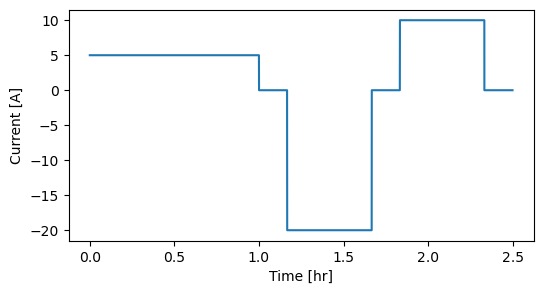

In [5]:
# Get theoretical capacity to determine currents
Qt = asoh.q_t.amp_hour

# Step 1: charge at C/2 for 1 hour to 100% SOC
size = 3600
timestamps = size * np.sort(np.random.random(size=size))
currents = [Qt / 2] * size
# Step 2: rest
size = 600
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [0.0] * size
# Step 3: discharge at 2C for 30 minutes to 0% SOC
size = 1800
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [-2 * Qt] * size
# Step 4: rest
size = 600
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [0.0] * size
# Step 5: charge at 1C for 1 hour to 100% SOC
size = 1800
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [Qt] * size

# Step 6: rest
size = 600
timestamps = np.append(timestamps, timestamps[-1] + size * np.sort(np.random.random(size=size)))
currents += [0.0] * size

# Checking to make sure we have the currents we want
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(timestamps/3600, currents)
ax.set_xlabel('Time [hr]')
_ = ax.set_ylabel('Current [A]')

The next step is to create a simulator which will create the data we'll use to fit the UKF.

In [6]:
simulator = ECMSimulator(asoh=asoh, transient_state=transient0, keep_history=True)

In order to prepare the UKF, we need to understand the statistics of all relevant variables, which, in this case, are
the SOC, hysteresis voltage, I_RC on the transient state side, and voltage on the measurement side. 

In [7]:
# For the SOC variance, let's assume it is a uniform distribution between 0 and 1. 
# Recall that the variance of the uniform distribution U[a,b] is given by ((b-a)**2)/12
soc_var = 1.0/12
# Similarly, for the hysteresis voltage, we will (wrongly) assume a uniform distribution from -M to M
hyst_max = asoh.h0.get_value(soc=0.5)
hyst_var = (4 * hyst_max * hyst_max) / 12
# For the current in the RC element, we will approximate it as the variance of the total current
irc_var = np.var(currents)

We will maintain the UKF process noise at its default value of 1.0e-08 for all variables, but set the sensor noise to a 
more realistic value corresponding to a voltage error of 1.0e-03 V (1 mV). 

We will also provide an initial state that is a bit off from the real initial state. 

In [8]:
# Calculating sensor noise. 
volt_err = 1.0e-03
sensor_noise = (volt_err / 2) ** 2

# Assembling UKF
initial_state = transient0.to_numpy() + \
    np.random.multivariate_normal(mean=np.zeros(3),
                                  cov=np.diag([soc_var, irc_var, hyst_var])
                                  )
print('Initial state provided to UKF: ', initial_state)

ukf = UKF(model=ECM(),
          initial_asoh=asoh,
          initial_transients=transient0,
          initial_inputs=ECMInput(time=0, current=0),
          initial_covariance=np.diag([soc_var, irc_var, hyst_var]),
          covariance_sensor_noise=sensor_noise*np.eye(1))

Initial state provided to UKF:  [[ 1.03200611 11.83850212 -0.02880232]]


Now, let's simulate the ECM and evolve the UKF concurrently. We will draw errors for voltage values from a white noise distribution to mimic a 1 mV error-level.

In [9]:
# Container for UKF predictions
noisy_voltage = []
ukf_predictions = {'transient': [], 'output': []}

for time, current in tqdm(zip(timestamps, currents), total=len(timestamps)):
    # Assemble simulator and UKF inputs
    sim_in = ECMInput(time=time, current=current)
    ukf_control = DeltaDistribution(mean=np.array([time, current, 25.]))
    # Step simulator
    transient, measurement = simulator.step(new_inputs=sim_in)
    # Prepare measurement for UKF and store noisy voltage
    vt = measurement.terminal_voltage.item() + np.random.normal(scale=(volt_err / 2))
    noisy_voltage += [vt]
    ukf_meas = DeltaDistribution(mean=np.array([vt]))
    ukf_prediction, ukf_transient = ukf.step(u=ukf_control, y=ukf_meas)
    ukf_predictions['transient'].append(ukf_transient)
    ukf_predictions['output'].append(ukf_prediction)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9000/9000 [00:15<00:00, 566.77it/s]


Now, let's plot these results!

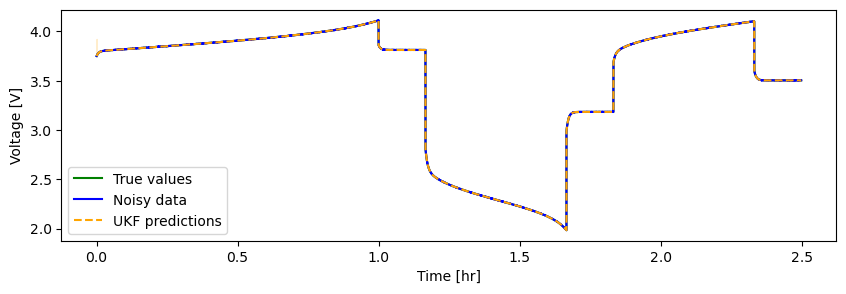

In [10]:
# Converting predictions to arrays for plotting
ukf_mean = pd.concat([
    pd.DataFrame([pred.mean.flatten() for pred in ukf_predictions['output']], columns=ukf.output_names),
    pd.DataFrame([pred.mean.flatten() for pred in ukf_predictions['transient']], columns=ukf.state_names)
], axis=1)
ukf_std = pd.concat([
    pd.DataFrame([np.sqrt(np.diag(pred.covariance)) for pred in ukf_predictions['output']], columns=ukf.output_names),
    pd.DataFrame([np.sqrt(np.diag(pred.covariance)) for pred in ukf_predictions['transient']], columns=ukf.state_names),
], axis=1)

# Voltages
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(timestamps / 3600,
        [out.terminal_voltage.item() for out in simulator.measurement_history[1:]],
        color='green',
        label='True values')
ax.plot(timestamps / 3600,
        noisy_voltage,
        color='blue',
        label='Noisy data')
ax.plot(timestamps / 3600,
        ukf_mean['terminal_voltage'],
        color='orange',
        linestyle='--',
        label='UKF predictions')
ax.fill_between(timestamps[1:] / 3600,  # very high initial uncertainty due to bad initialization (delta_SOC = 35%!)
                (ukf_mean['terminal_voltage'] + 2 * ukf_std['terminal_voltage'])[1:],
                (ukf_mean['terminal_voltage'] + 2 * ukf_std['terminal_voltage'])[1:],
                color='orange', 
                alpha=0.2)
ax.legend()
ax.set_ylabel('Voltage [V]')
_ = ax.set_xlabel('Time [hr]')

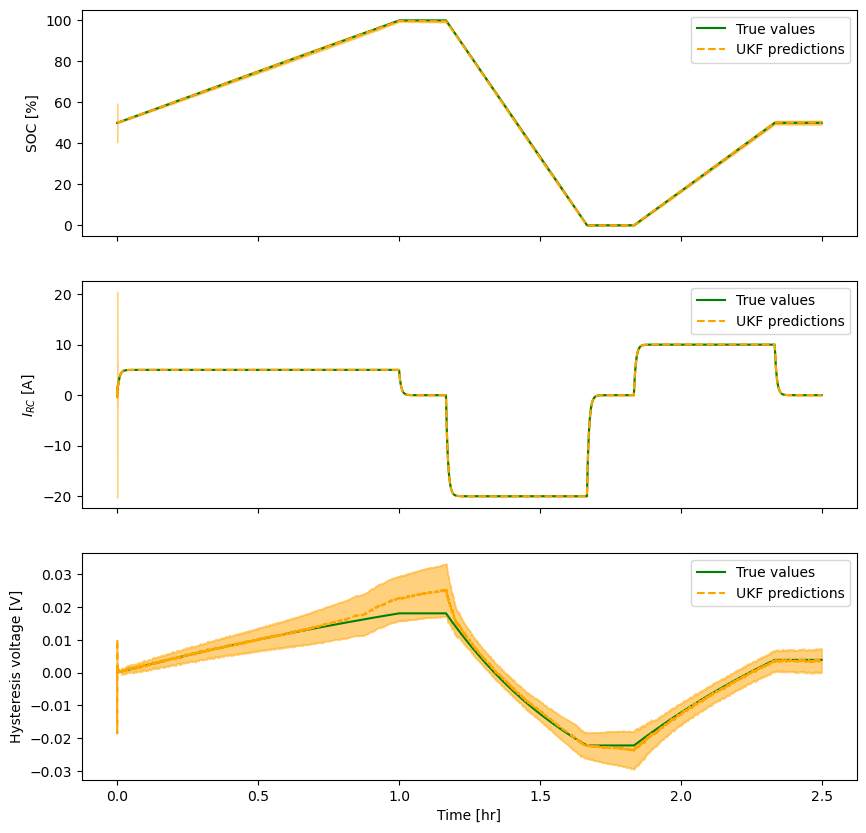

In [11]:
# SOC, I_RC, Hyst
fig, ax = plt.subplots(3, 1, figsize=(10,10), sharex='col')
ax[0].plot(timestamps / 3600,
           100 * np.array([transient.soc.item() for transient in simulator.transient_history[1:]]),
           color='green',
           label='True values')
ax[0].plot(timestamps / 3600,
           100 * ukf_mean['soc'],
           linestyle='--',
           color='orange',
           label='UKF predictions')
ax[0].fill_between(timestamps / 3600,
                   100 * (ukf_mean['soc'] + 2 * ukf_std['soc']),
                   100 * (ukf_mean['soc'] - 2 * ukf_std['soc']),
                   color='orange',
                   alpha=0.5)
ax[1].plot(timestamps / 3600,
           [transient.i_rc[0] for transient in simulator.transient_history[1:]],
           color='green',
           label='True values')
ax[1].plot(timestamps / 3600,
           ukf_mean['i_rc'],
           color='orange',
           linestyle='--',
           label='UKF predictions')
ax[1].fill_between(timestamps / 3600,
                   ukf_mean['i_rc'] + 2 * ukf_std['i_rc'],
                   ukf_mean['i_rc'] - 2 * ukf_std['i_rc'],
                   color='orange',
                   alpha=0.5)
ax[2].plot(timestamps / 3600,
           [transient.hyst.item() for transient in simulator.transient_history[1:]],
           color='green',
           label='True values')
ax[2].plot(timestamps / 3600,
           ukf_mean['hyst'],
           color='orange',
           linestyle='--',
           label='UKF predictions')
ax[2].fill_between(timestamps[60:] / 3600,  # for the first 1 minute, uncertainty dominates in hysteresis
                   (ukf_mean['hyst'] + 2 * ukf_std['hyst'])[60:],
                   (ukf_mean['hyst'] - 2 * ukf_std['hyst'])[60:],
                   color='orange',
                   alpha=0.5)
ax[0].legend()
ax[1].legend()
ax[2].legend()
ax[0].set_ylabel('SOC [%]')
ax[1].set_ylabel(r'$I_{RC}$ [A]')
ax[2].set_ylabel('Hysteresis voltage [V]')
_ = ax[2].set_xlabel('Time [hr]')